In [9]:
import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.models import Model
from tqdm import tqdm_notebook as tqdm
import zipfile as zf

In [10]:
os.getcwd()

'C:\\Users\\rsmvs'

In [13]:
os.chdir('C:\\Users\\rsmvs\\OneDrive\\Desktop')

In [14]:
dataset = zf.ZipFile("plant-pathology-2020-fgvc7.zip","r")

In [15]:
dataset.extractall("apple_dataset")

In [17]:
train_data =pd.read_csv(r"C:\Users\rsmvs\OneDrive\Desktop\apple_dataset\train.csv")
test_data = pd.read_csv(r"C:\Users\rsmvs\OneDrive\Desktop\apple_dataset\test.csv")

In [18]:
print("Training data shape : = {}".format(train_data.shape))
print("Test data shape : = {}".format(test_data.shape))

Training data shape : = (1821, 5)
Test data shape : = (1821, 1)


In [19]:
train_data.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [20]:
# category - for each image_id 
def convert_dummies_to_category(df):
    data = df.copy()
    s2 = data[['healthy','multiple_diseases','rust','scab']].idxmax(axis=1)
    data = pd.concat([data,s2],axis=1)
    data.rename({0:'category'},axis=1,inplace=True)
    return data
  
# apply above function to find the category of the image
train_df = convert_dummies_to_category(train_data)
train_df.head()

image_id  healthy  multiple_diseases  rust  scab           category
0  Train_0        0                  0     0     1               scab
1  Train_1        0                  1     0     0  multiple_diseases
2  Train_2        1                  0     0     0            healthy
3  Train_3        0                  0     1     0               rust
4  Train_4        1                  0     0     0            healthy

In [21]:
image_folder_path = r"C:\Users\rsmvs\OneDrive\Desktop\apple_dataset\images"

In [22]:
arr = train_data["image_id"]
train_images = [i for i in arr]  

arr = test_data["image_id"]
test_images = [i for i in arr]

In [23]:
def load_image(image_id):
    image_path = os.path.join(image_folder_path, image_id + '.jpg')
    if not os.path.exists(image_path):
        print(f"Error: image file {image_path} not found.")
        return None
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: could not read image file {image_path}.")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


In [24]:
#Function for resize images
def resize(image, image_size):
    if image is None or image.size == 0:
        return None

    image = cv2.resize(image, (image_size[1], image_size[0]), interpolation=cv2.INTER_AREA)
    return image

In [25]:
#idhar EDA perform kar rhe h

count_healthy = len(train_data[train_data["healthy"] == 1])
count_diseased = len(train_data[train_data["multiple_diseases"] == 1])
count_rust = len(train_data[train_data["rust"] == 1])
count_scab = len(train_data[train_data["scab"] == 1])

print("The count of healthy images :",count_healthy)
print("The count of Multiple diseases images :",count_diseased)
print("The count of rust images :",count_rust)
print("The count of scab images :",count_scab)
print("The total of images: ",count_healthy + count_diseased + count_rust +  count_scab)

The count of healthy images : 516
The count of Multiple diseases images : 91
The count of rust images : 622
The count of scab images : 592
The total of images:  1821


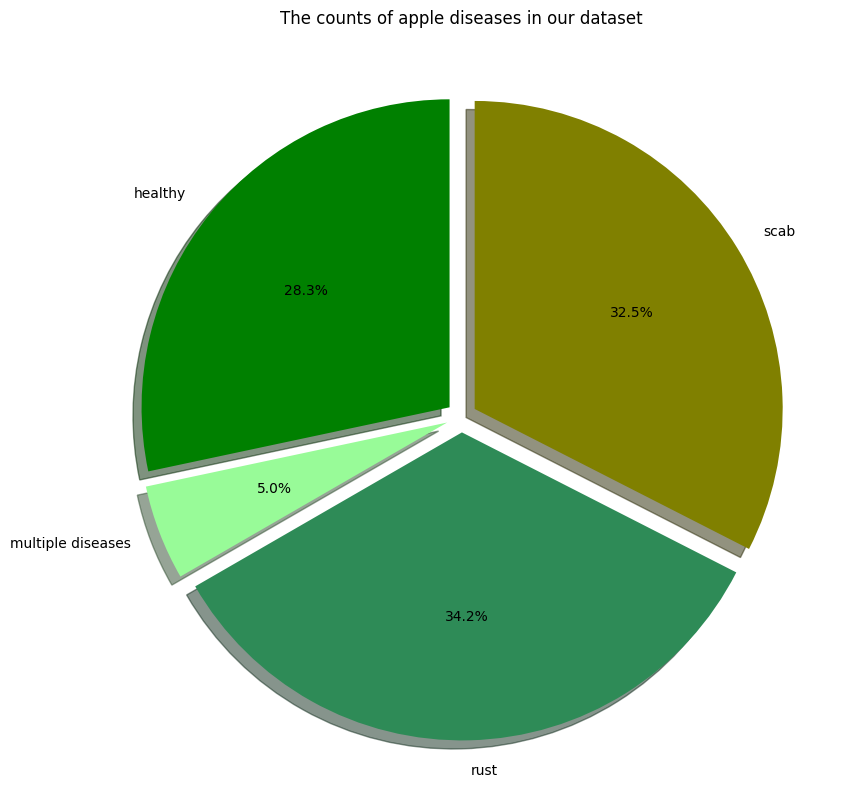

In [26]:
labels= ['healthy','multiple diseases','rust','scab']
counts = [count_healthy, count_diseased, count_rust, count_scab]
fig, ax = plt.subplots(figsize = (15, 10))
explode = (0.05, 0.05, 0.05, 0.05)
colors = ['green', 'palegreen', 'seagreen', 'olive']
ax.pie(counts, labels=labels,colors = colors, explode =explode,autopct='%1.1f%%', shadow = True, startangle=90)
plt.title('The counts of apple diseases in our dataset')
plt.show()

In [27]:
def get_img_label(img):
    ''' function to fetch the category of the image'''
    if search("Train",img):
        img = img.split('.')[0]
        category = train_df.loc[train_df['image_id']==img]['category']
        return category

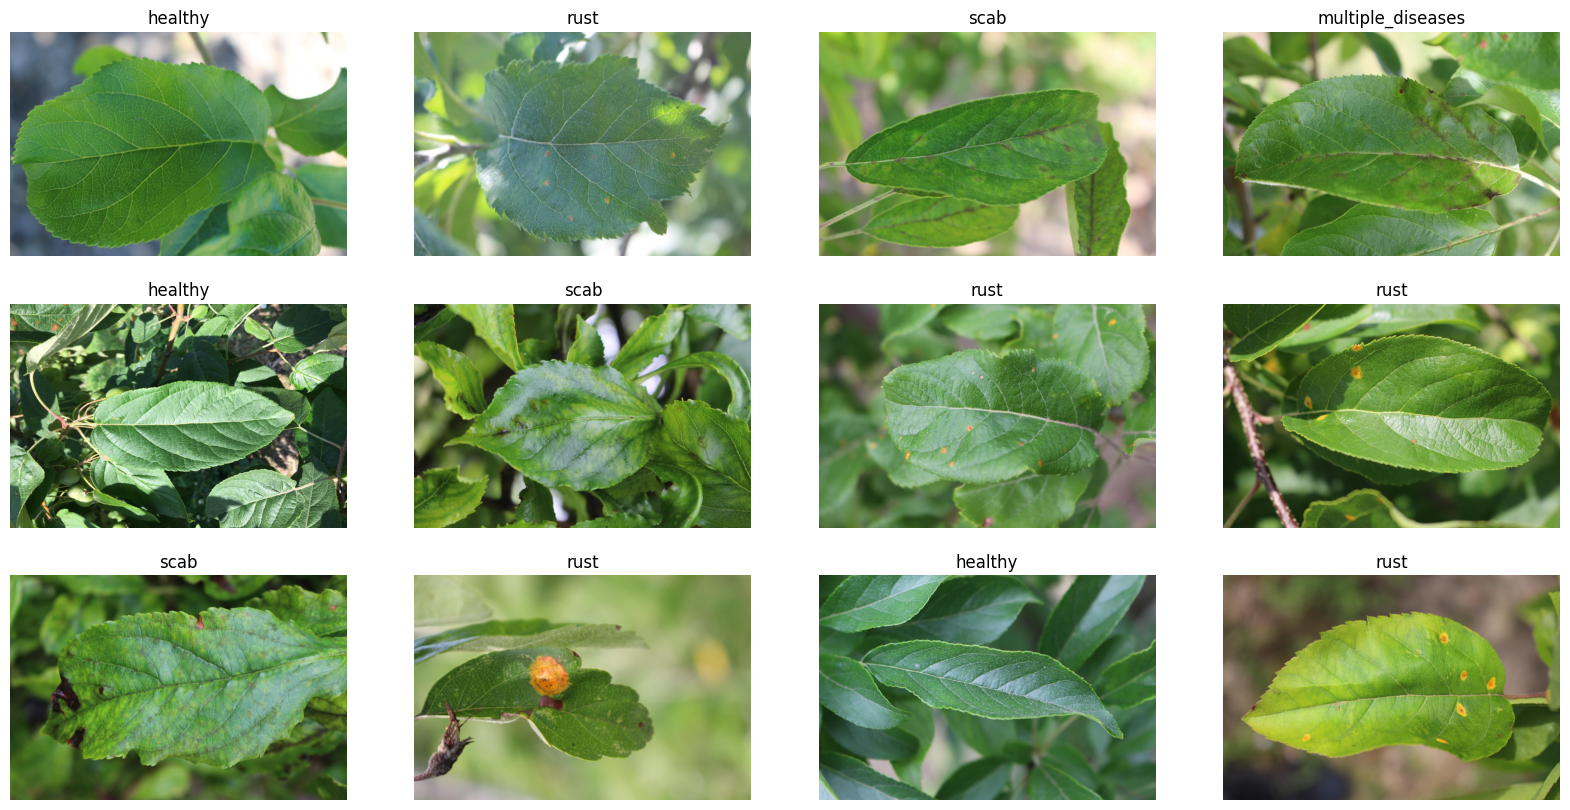

In [28]:
# lets check some images 
import random
import glob
from re import search
import matplotlib.image as mpimg
random_images = random.sample(glob.glob(os.path.join(image_folder_path,"Train_*.jpg")),12)
random_id = [img_path.split('\\')[-1] for img_path in random_images]


plt.figure(figsize=(20, 10))
for idx, img_path in enumerate(random_id):
    img_title = get_img_label(img_path)
    sp = plt.subplot(3, 4, idx+1)
    sp.axis('Off')
    complete_path = os.path.join(image_folder_path,img_path)
    mp_image = mpimg.imread(complete_path)
    plt.title(img_title.values[0])
    plt.imshow(mp_image) 

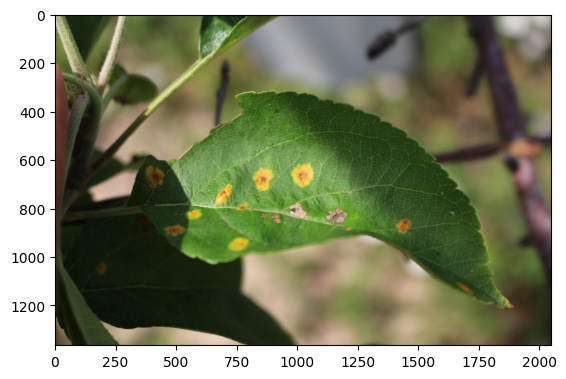

In [29]:
from PIL import Image

# Load the image from a file
sample_image = Image.open('apple_dataset\images\Train_37.jpg')

# Display the image
plt.imshow(sample_image)
plt.show()


In [30]:
image = cv2.imread('apple_dataset\images\Train_37.jpg')

# Convert the image to a NumPy ar|ray
img_array = np.array(image)

# Print the shape of the array
print(img_array.shape)

(1365, 2048, 3)


In [31]:
#Create a function for image Denoising 
def non_local_means_denoising(image) : 
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None,  10, 10, 7, 21)
    return denoised_image

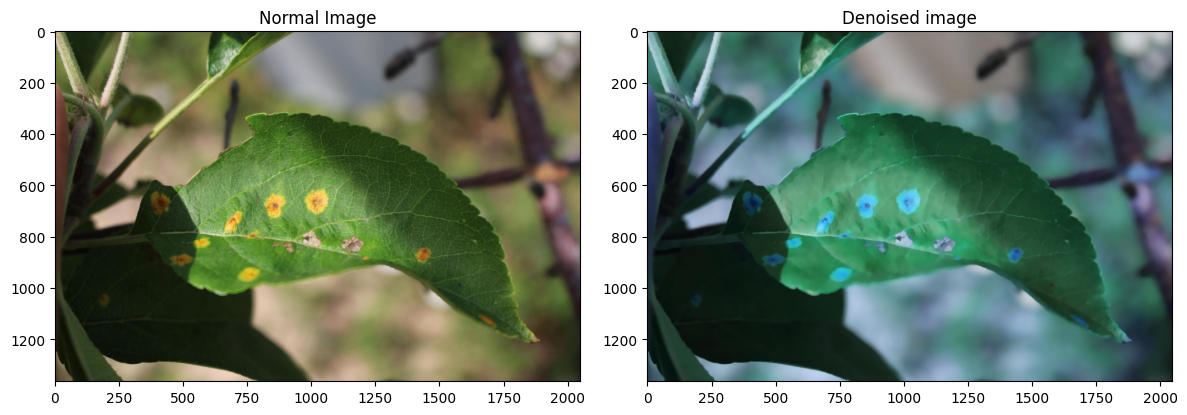

In [32]:
denoised_image = non_local_means_denoising(image)

plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image")

plt.subplot(1,2,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised image")    
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

In [33]:
#2-Edge detection Using sobel filter

def sobel_edge_detection(image):
    
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    return sobelx, sobely
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-475.0..350.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-461.0..620.0].


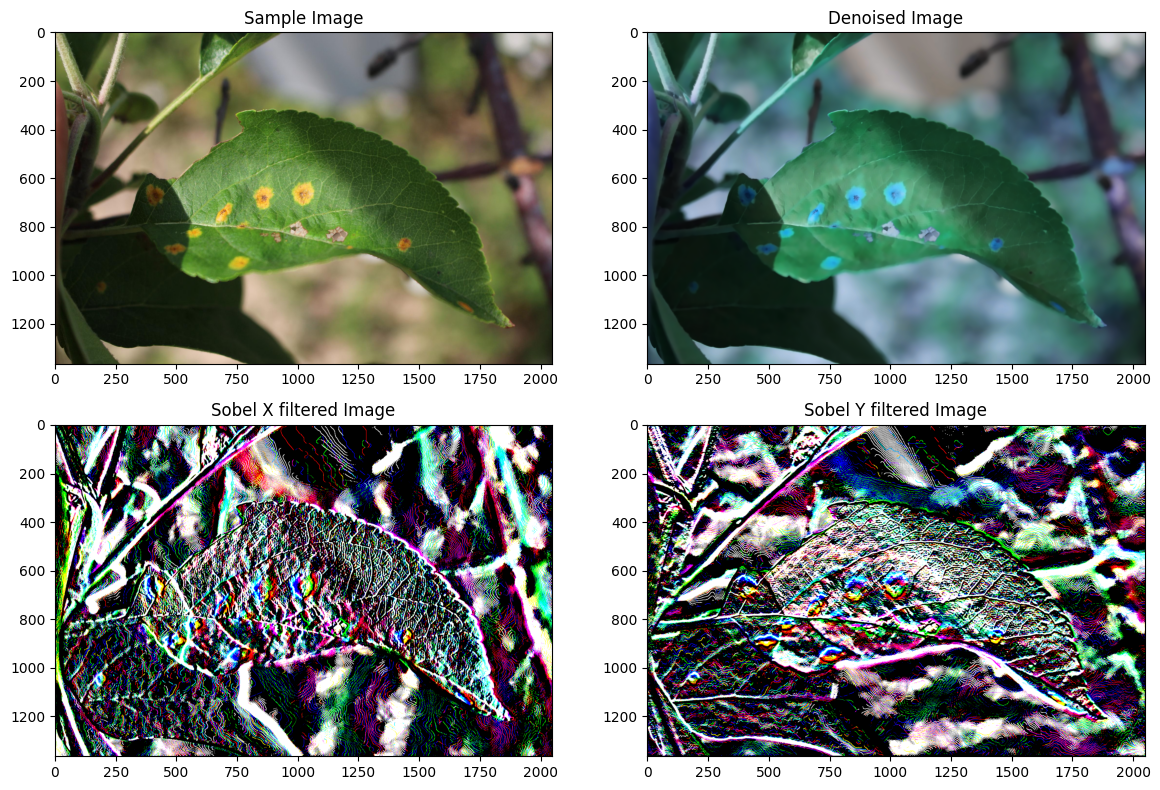

In [34]:
s_img_x, s_img_y = sobel_edge_detection(denoised_image)

plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Sample Image")

plt.subplot(2,2,2)
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised Image")

plt.subplot(2,2,3)
plt.imshow(s_img_x, cmap = "gray")
plt.grid(False)
plt.title("Sobel X filtered Image")

plt.subplot(2,2,4)
plt.imshow(s_img_y, cmap = "gray")
plt.grid(False)
plt.title("Sobel Y filtered Image")

# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

In [35]:
#image segmentation

def segmentation(image, k, attempts) : 
    vectorized = np.float32(image.reshape((-1, 3)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    res , label , center = cv2.kmeans(vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    
    segmented_image = res.reshape((image.shape))
    return segmented_image

Text(0.5, 1.0, 'Segmented Image with k = 5')

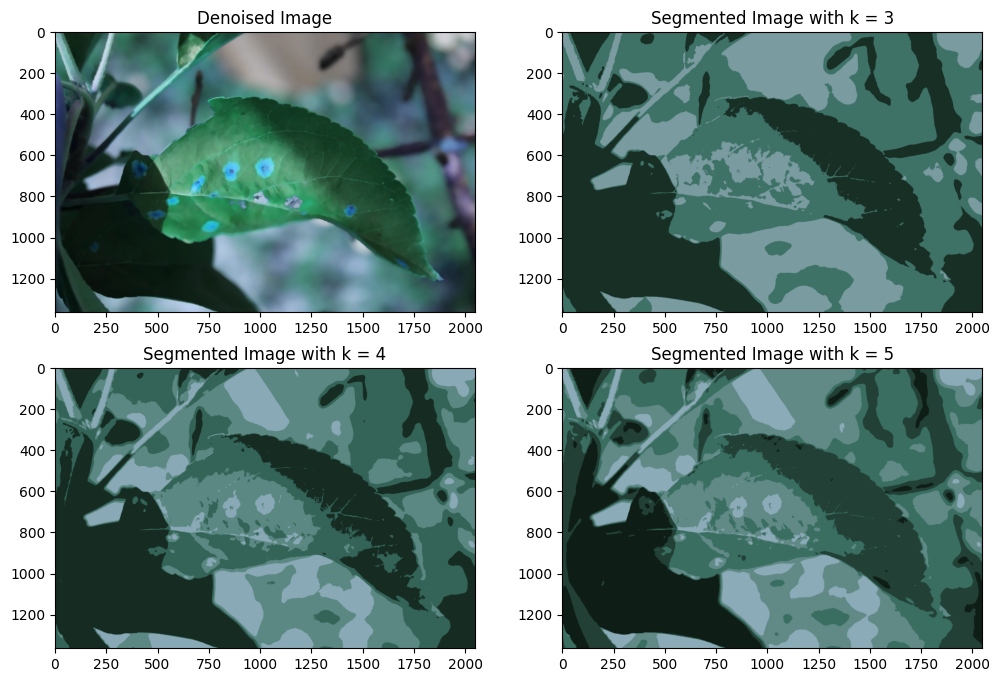

In [36]:
plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised Image")

segmented_image = segmentation(denoised_image, 3, 10) # k = 3, attempt = 10
plt.subplot(2,2,2)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 3")

segmented_image = segmentation(denoised_image, 4, 10) # k = 4, attempt = 10
plt.subplot(2,2,3)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 4")

segmented_image = segmentation(denoised_image, 5, 10) # k = 5, attempt = 10
plt.subplot(2,2,4)
plt.imshow(segmented_image, cmap = "gray")
plt.grid(False)
plt.title("Segmented Image with k = 5")

In [40]:
#Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# define the data augmentation pipeline
data_aug = ImageDataGenerator(rotation_range=40,
                              zoom_range=0.2,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              horizontal_flip=True,
                             fill_mode='nearest')


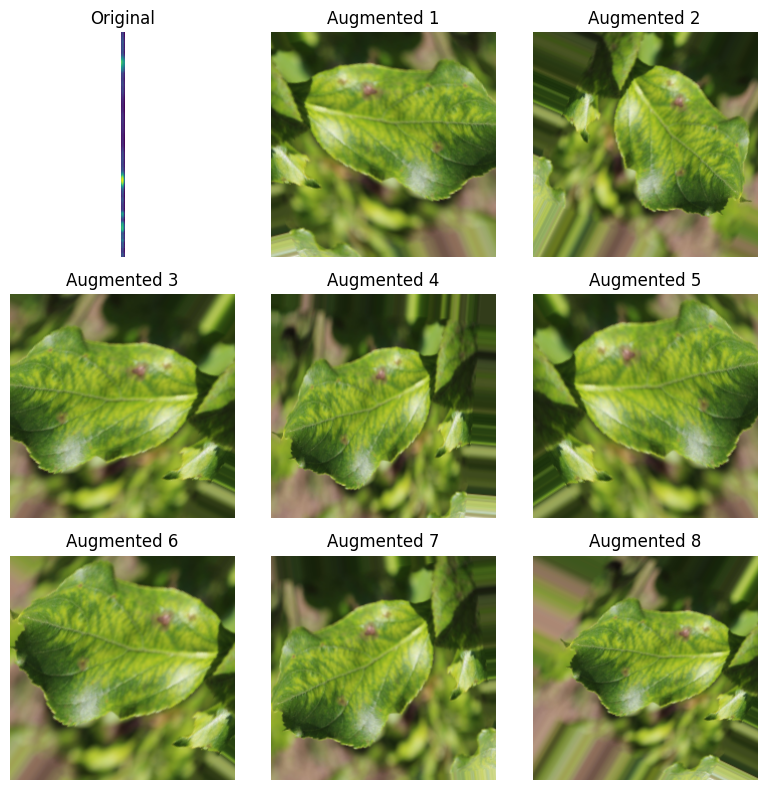

In [46]:
def augment_images(image):
    image_batch = np.expand_dims(image, axis=0)  # shape: (1, H, W, C)
    data = data_aug.flow(image_batch, batch_size=1)
    return next(data)[0].astype('uint8')


# Plotting augmented images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()
axes[0].imshow(image[0].astype('uint8'))
axes[0].set_title('Original')
axes[0].axis('off')

for i in range(1, 9):
    augmented = augment_images(image)
    axes[i].imshow(augmented)
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [47]:
IMAGE_SIZE = (224, 224, 3)

In [48]:
train_image = []
for id in tqdm(train_data["image_id"]):
    image = load_image(id)
    image = resize(image, IMAGE_SIZE)
    
    seg_image = segmentation(image, 4, 10)
    aug_images = augment_images(image)
    edge_detection = sobel_edge_detection(image)
    
    
    train_image.append(image)

C:\Users\rsmvs\AppData\Local\Temp\ipykernel_5180\1544150181.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for id in tqdm(train_data["image_id"]):


  0%|          | 0/1821 [00:00<?, ?it/s]

In [49]:
x_train = np.array(train_image)
x_train = x_train/255.0
y = train_data.copy()
del y["image_id"]
y_train = np.array(y.values)

In [50]:
print(x_train.shape)
print(y_train.shape)

(1821, 224, 224, 3)
(1821, 4)


In [51]:
sample = x_train[100]
sample.shape

(224, 224, 3)

Label =  [1 0 0 0]


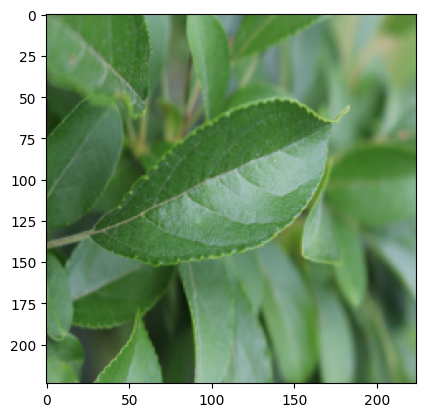

In [52]:
plt.imshow(sample)
print("Label = ", y_train[5])

In [54]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 115)
x_train, y_train = smote.fit_resample(x_train.reshape((-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * 3)), y_train)
x_train = x_train.reshape((-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
print(x_train.shape)
print(y_train.shape)

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
    --------------------------------------- 0.3/12.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.6 MB 1.5 MB/s eta 0:00:09
   -- ------------------------------------- 0.8/12.6 MB 1.6 MB/s eta 0:00:08
   --- ------------------------------------ 1.0/12.6 MB 1.4 MB/s eta 0:00:09
   ---- ----------------------------------- 1.3/12.6 MB 1.4 MB/s eta 0:00:09
   ---- ----------------------------------- 1.6/12.6 MB 1.3 MB/s eta 0:00:09
   ----- ---------------------------------- 1.8/12.6 MB 1.3 MB/s eta 0:00:09
   ------- -------------------------------- 2.4/12.6 MB 1.5 MB/s eta 0:00:08
   --------- ------------------------------ 2.9/12.6 MB 1.6 MB/s eta 0:00:07
   ---------- ----------------------------- 3.4/12.6 MB 1.6 MB/s eta 0:00:06
   ----------- ---------------------------- 3.7/12.6

ModuleNotFoundError: No module named 'imblearn'

In [55]:
y_train


array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]], dtype=int64)

In [56]:
def label_count(label) :    
    count = 0 
    for entry in y_train :
        if np.array_equal(label, entry):    
            count += 1
    return count     

In [57]:
healthy = np.array([1,0,0,0])
multiple_diseases = np.array([0,1,0,0])
rust = np.array([0,0,1,0])
scab = np.array([0,0,0,1])

In [58]:
count_healthy = label_count(healthy)
count_multiple_diseases = label_count(multiple_diseases)
count_rust = label_count(rust)
count_scab = label_count(scab)
print("The count of healthy images :",count_healthy)
print("The count of Multiple diseases images :",count_multiple_diseases )
print("The count of rust images :",count_rust)
print("The count of scab images :",count_scab)
print("The total of images: ",count_healthy + count_multiple_diseases  + count_rust +  count_scab)

The count of healthy images : 516
The count of Multiple diseases images : 91
The count of rust images : 622
The count of scab images : 592
The total of images:  1821


([<matplotlib.patches.Wedge at 0x270190a8f40>,
 [Text(-0.8937802542539106, 0.7236413870874268, 'Healthy'),
  Text(-1.073581967655483, -0.41221567015942207, 'Multiple Diseased'),
  Text(0.029756287421660296, -1.1496149630893293, 'Rust'),
  Text(0.9807176376386028, 0.600577151766997, 'Scab')],
 [Text(-0.505180143708732, 0.4090146970494151, '28.3%'),
  Text(-0.6068071991096209, -0.232991465742282, '5.0%'),
  Text(0.01681877115137321, -0.6497823704417947, '34.2%'),
  Text(0.5543186647522537, 0.3394566509987374, '32.5%')])

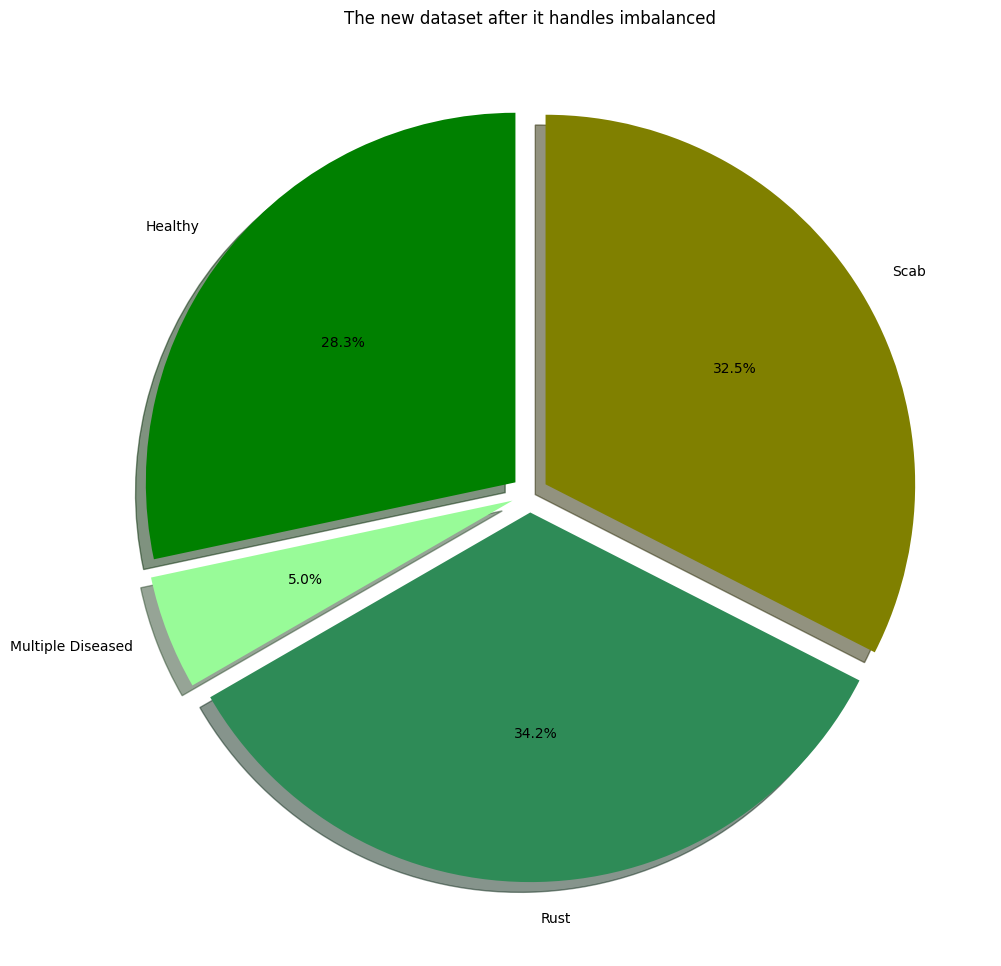

In [59]:
labels = ["Healthy", "Multiple Diseased", "Rust", "Scab"]
counts = [count_healthy, count_multiple_diseases, count_rust, count_scab]
explode = (0.05, 0.05, 0.05, 0.05)
colors = ['green', 'palegreen', 'seagreen', 'olive']
fig, ax = plt.subplots(figsize = (20, 12))
plt.title('The new dataset after it handles imbalanced')

ax.pie(counts, explode = explode, labels = labels, colors=colors, autopct='%1.1f%%', shadow = True, startangle = 90)


In [60]:
VALIDATION_FACTOR = 0.1

val_size = int(len(x_train) * VALIDATION_FACTOR)

train_x = x_train[: len(x_train) - val_size]
train_y = y_train[: len(y_train) - val_size] # len(x_train) = len(y_train)

val_x = x_train[len(x_train) - val_size : len(x_train)]
val_y = y_train[len(y_train) - val_size : len(y_train)]

print("Shape of training data = ", train_x.shape, train_y.shape)
print("Shape of validation data = ", val_x.shape, val_y.shape)

Shape of training data =  (1639, 224, 224, 3) (1639, 4)
Shape of validation data =  (182, 224, 224, 3) (182, 4)


In [61]:
#Configure GPU for deep learning

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
if len(gpus) == 1 : 
    strategy = tf.distribute.OneDeviceStrategy(device = "/gpu:0")
else:
    strategy = tf.distribute.MirroredStrategy()
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision" : True})
print("Mixed precision enabled")

[]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Mixed precision enabled


In [67]:
def get_bottleneck_features(deep_learning_model, input_images) :
   
    with tf.device("/device:GPU:0"):
        bottleneck_features = deep_learning_model.predict(input_images, verbose = 1)
        return bottleneck_features


In [68]:
vgg = tf.keras.applications.vgg16.VGG16(include_top = False, weights = "imagenet", input_shape = IMAGE_SIZE)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 56s 1us/step


In [72]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [73]:
vgg.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor>

In [74]:
vgg.layers[-1].output

<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_18>

In [75]:
output = vgg.layers[-1].output
output = tf.keras.layers.GlobalAveragePooling2D()(output)
vgg_model = tf.keras.models.Model(vgg.input, output)

In [76]:
for layer in vgg.layers:
    layer.trainable=False

In [77]:
training_bottleneck_features = get_bottleneck_features(vgg_model, train_x)
validation_bottleneck_features = get_bottleneck_features(vgg_model, val_x)
print("Shape of training bottleneck features = ", training_bottleneck_features.shape)
print("Shape of validation bottleneck features = ", validation_bottleneck_features.shape)

52/52 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step
Shape of training bottleneck features =  (1639, 512)
Shape of validation bottleneck features =  (182, 512)


In [79]:
vgg_model.output_shape[1]

512

In [80]:
from tensorflow.keras.regularizers import l2
input_shape = vgg_model.output_shape[1]

VGG_model = tf.keras.models.Sequential()
VGG_model.add(tf.keras.layers.InputLayer(input_shape = (input_shape, )))

VGG_model.add(tf.keras.layers.Dense(512, activation = "relu", input_dim = input_shape))
#VGG_model.add(tf.keras.layers.Dropout(0.2))


VGG_model.add(tf.keras.layers.Dense(512, activation = "relu"))
#VGG_model.add(tf.keras.layers.Dropout(0.2))
#VGG_model.add(tf.keras.layers.BatchNormalization())
VGG_model.add(tf.keras.layers.Dense(512, activation = "relu"))

          
VGG_model.add(tf.keras.layers.Dense(4, activation = "softmax"))

VGG_model.summary() 

C:\Users\rsmvs\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\rsmvs\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 790,020 (3.01 MB)

 Trainable params: 790,020 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
VGG_model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

In [84]:
BATCH_SIZE = 64
EPOCHS = 10
with tf.device("/device:GPU:0"): #with tf.device("/device:GPU:0"):
    history = VGG_model.fit(x = training_bottleneck_features, 
                        y = train_y,
                        validation_data = (validation_bottleneck_features, val_y),
                        batch_size = BATCH_SIZE, 
                        epochs= EPOCHS, 
                        verbose = 1,
                       )

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9937 - loss: 0.0153 - val_accuracy: 0.7308 - val_loss: 1.7798
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9996 - loss: 0.0041 - val_accuracy: 0.7143 - val_loss: 1.8989
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9986 - loss: 0.0051 - val_accuracy: 0.7033 - val_loss: 1.8469
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9966 - loss: 0.0046 - val_accuracy: 0.7143 - val_loss: 1.8689
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.7253 - val_loss: 1.8776
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.7308 - val_loss: 1.9331
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.7418 - val_loss: 1.9626
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.7143 - v

In [91]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu',input_shape = (224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #Ajouter le 2éme couche de convolution
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #étaller les données en un seul vecteur
    tf.keras.layers.Flatten(),
    #Les couches fully connected
    tf.keras.layers.Dense(512,activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')

])
cnn_model.summary()

C:\Users\rsmvs\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      95,552,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,573,444 (364.58 MB)

 Trainable params: 95,573,444 (364.58 MB)

 Non-trainable params: 0 (0.00 B)